In [1119]:
%load_ext autoreload
%autoreload 2

from ff_energy.simulations import charmm, plots
import matplotlib.pyplot as plt

from ase import Atoms
from ase.geometry import find_mic
import ase.io
from typing import List
import MDAnalysis.analysis.msd as msd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from ase import Atoms
import numpy as np
from ase.io import write
from PIL import Image
from ase.visualize.plot import plot_atoms




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1120]:
# cl = charmm.read_charmm_log("/home/boittier/pcbach/test_water_sim_ewald/dynamics.log")

In [1124]:
# jobpath = "/home/boittier/pcbach/kmdcm_water_sim_rkhs/dynamics.log"
jobpath = "/home/boittier/pcbach/sims/kmdcm/water/k300/dynamics.log"
# jobpath = "/home/boittier/pcbach/test_water_sim_ewald/dynamics.log"
# jobpath = "/home/boittier/pcbach/kmdcm_water_sim/dynamics.log"
# jobpath = "/home/boittier/pcbach/mdcm_water_sim/dynamics.log"
# jobpath = "/home/boittier/pcbach/shake/dynamics.log"
cl = charmm.read_charmm_log(jobpath)

water.2000.heat.dcd
water.2000.equi.dcd


In [1128]:
vol = cl[cl["dyna"] == "2: DYNA RESTRT CPT" ][cl["volume"] > 30000].volume.median()
vol = 53646.47826
print(vol)
from pint import UnitRegistry
ureg = UnitRegistry()
volume = vol
nmol = 2000
ans = nmol*2.988*10**(-23)/volume * ureg("g/angstrom**3")
print(ans.to("kg/m**3"))


/tmp/ipykernel_128188/1800774679.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vol = cl[cl["dyna"] == "2: DYNA RESTRT CPT" ][cl["volume"] > 30000].volume.median()


53646.47826
1113.959423587333 kilogram / meter ** 3


plotting
['0: DYNA STRT VERL', '1: DYNA RESTRT CPT']


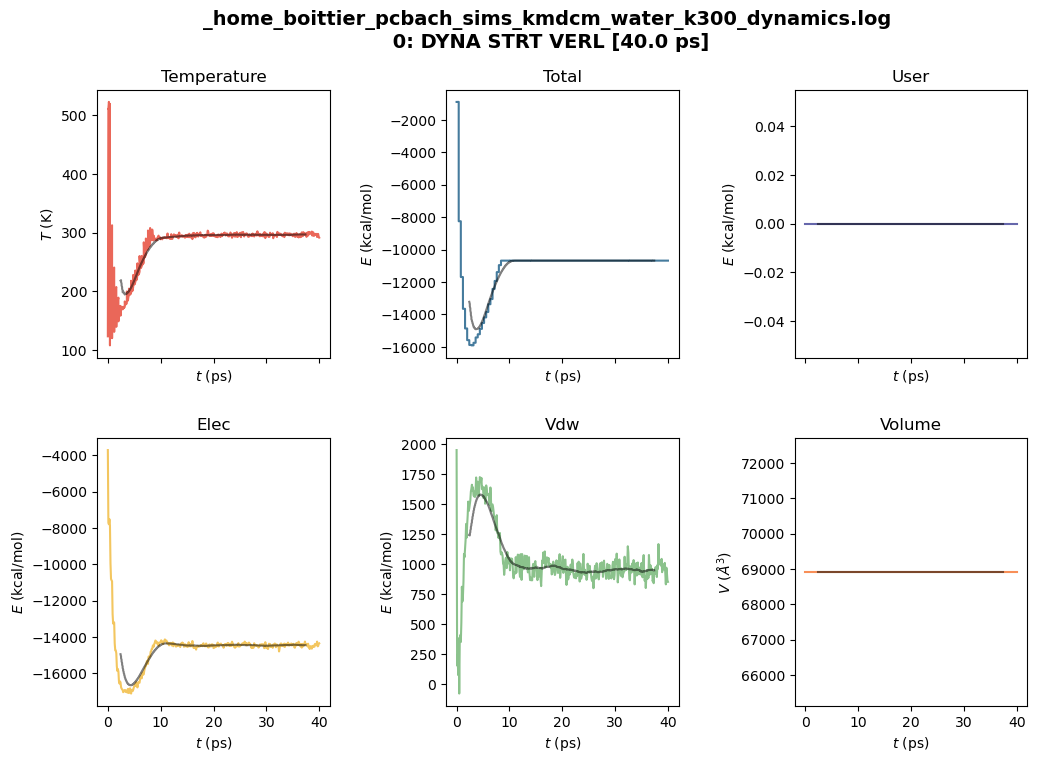

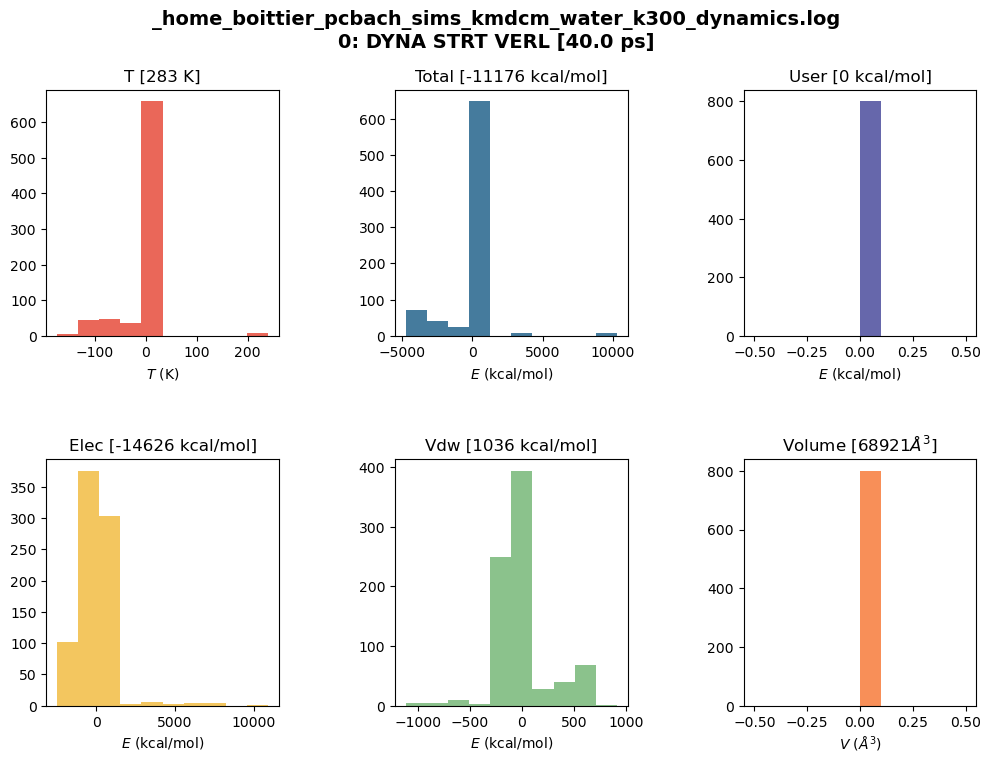

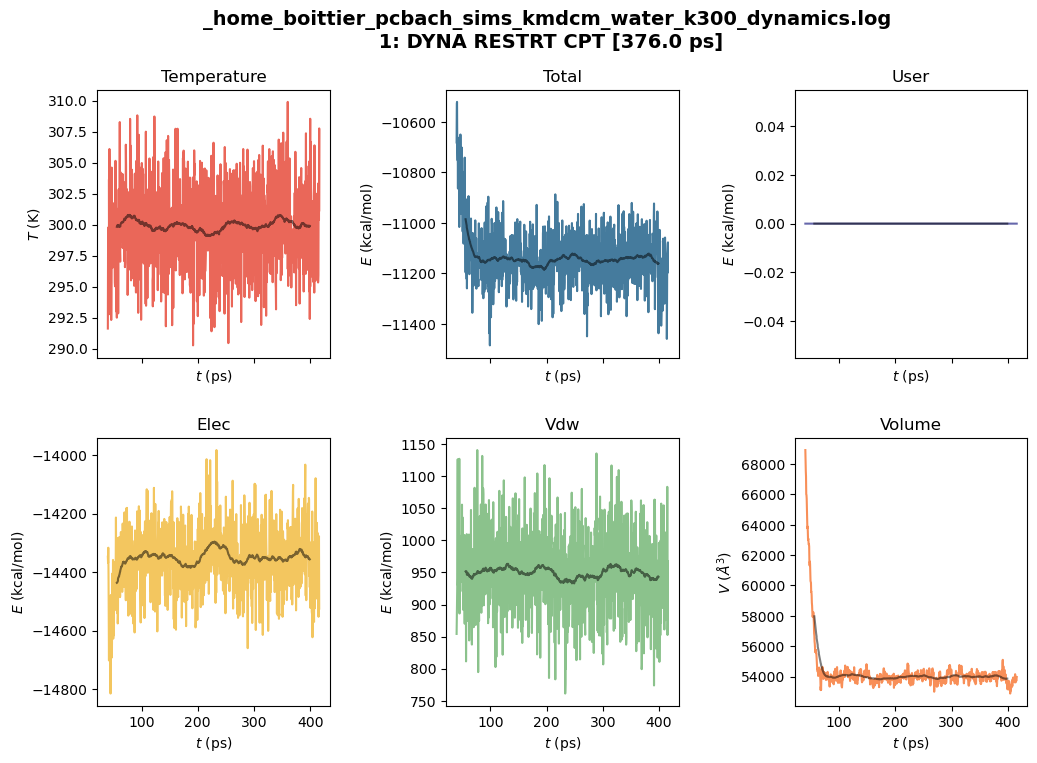

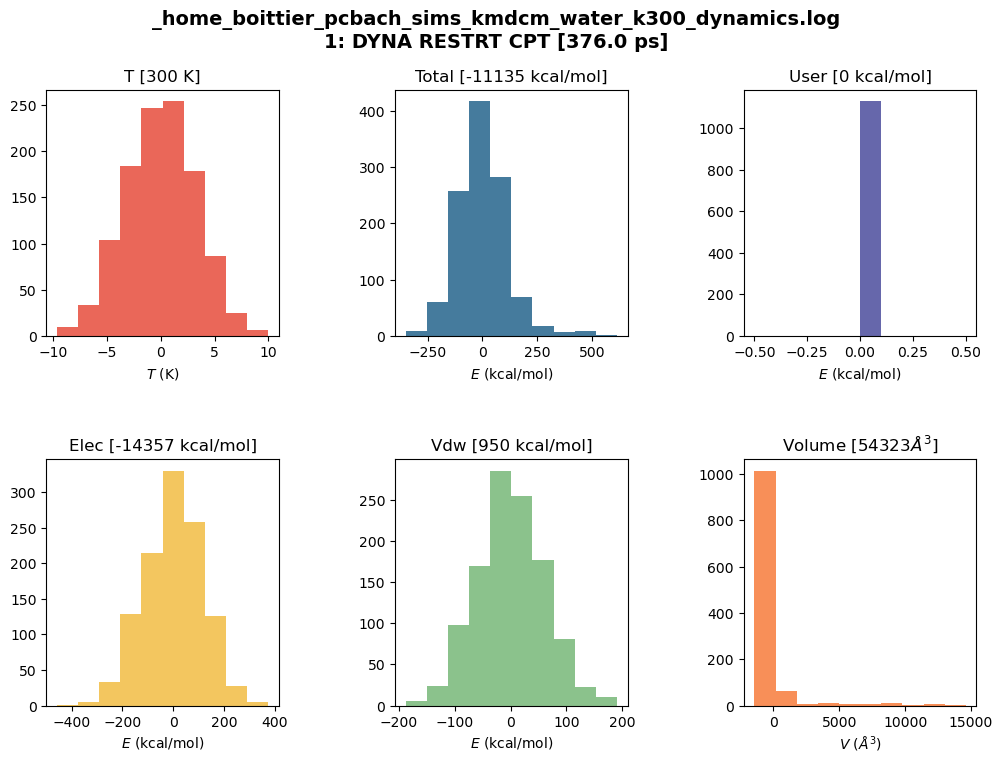

In [1126]:
plots.make_plots(cl)

In [1102]:
from ase.visualize import view
import MDAnalysis as mda

In [1103]:
# fn = "water.2000.equi.dcd"
fn = "water.2000.dyna.dcd"
from pathlib import Path
dcdpath = Path(jobpath).parents[0] / fn
psfpath = Path(jobpath).parents[0] / "water.2000.psf"

In [1104]:
u

<Universe with 6000 atoms>

In [1105]:
u = mda.Universe(psfpath, dcdpath)

/home/boittier/miniconda3/envs/pycharmm/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [1106]:
type(u._topology)
u.trajectory

<DCDReader /home/boittier/pcbach/mdcm_water_sim/water.2000.dyna.dcd with 15 frames of 6000 atoms>

In [1107]:
atoms = u.select_atoms("all")
# for _ in u.trajectory[::100]:
    
def get_ase_atoms(u):
    ase_atoms = Atoms(atoms.masses, atoms.positions, cell = u.dimensions)
    Z = np.tile(np.array([8, 1, 1]), 2000)
    ase_atoms.set_atomic_numbers(Z)
    ase_atoms.set_cell(u.dimensions)
    mid = ase_atoms.get_cell()/2
    ase_atoms.translate(mid.diagonal())
    return ase_atoms

def plot_atoms(atoms, ax):
    write('image.png', atoms,rotation='80z,-80x')
    img = np.asarray(Image.open('image.png'))
    imgplot = ax.imshow(img)
    return ax

In [1108]:
ATOMS = []

for _ in u.trajectory:
    ATOMS.append(get_ase_atoms(u))
    

def unwrap(frames: List[Atoms], initial_reference: Atoms=None) -> List[Atoms]:
    """Modifies ``frames`` in-place."""
    if initial_reference is not None:
        ref_frame = initial_reference
    else:
        ref_frame = frames[0]
        frames = frames[1:]

    for frame in frames:
        ref_cart_coords = ref_frame.positions
        cart_coords = frame.positions
        cart_diff, _ = find_mic(cart_coords-ref_cart_coords, cell=frame.cell)
        new_cart_coords = ref_cart_coords + cart_diff
        frame.positions[:] = new_cart_coords
        ref_frame = frame
        

unwrap(ATOMS)


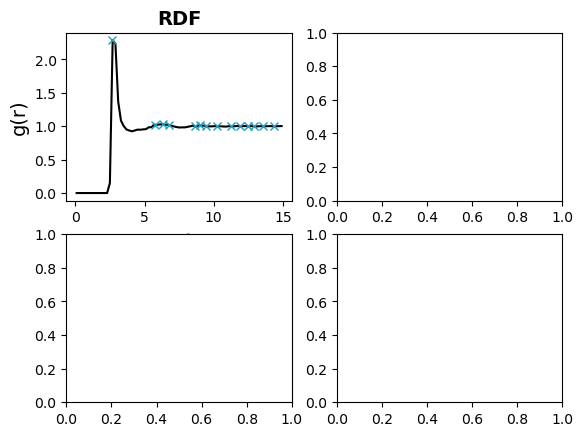

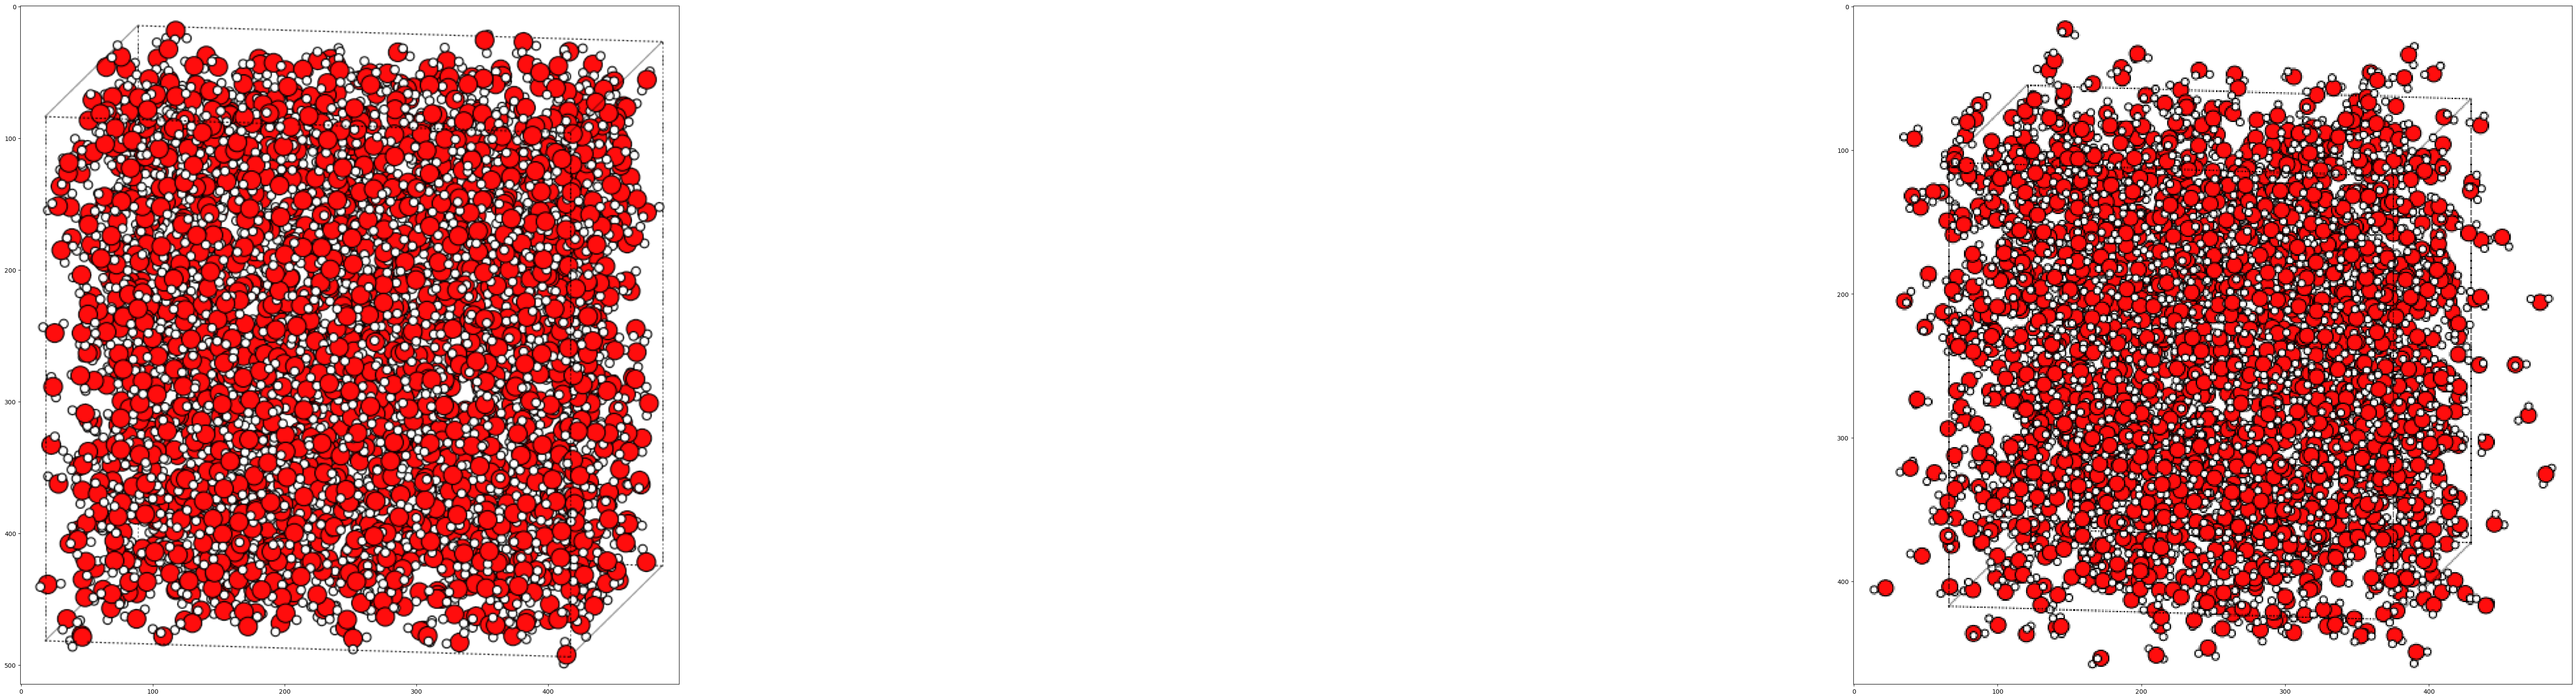

In [1109]:
fig, ax = plt.subplots(2,2)
plots.plot_rdf(ax[0,0], u, step=1)
fig, ax = plt.subplots(1,len(ATOMS)//10+1, figsize=(100, 20))
for i, a in enumerate(ATOMS[::10]):
    # a = get_ase_atoms(u)
    # a = ATOMS[-1]
    plot_atoms(a, ax[i])

In [1110]:
1000000/10000
80 * 1000

80000

In [1111]:
len(ATOMS)

15

In [1112]:
class DiffusionCoefficient:

    def __init__(self, traj, timestep, atom_indices=None, molecule=False):
        """

        This class calculates the Diffusion Coefficient for the given Trajectory using the Einstein Equation:

        ..math:: \\left \\langle  \\left | r(t) - r(0) \\right | ^{2} \\right \\rangle  = 2nDt

        where r(t) is the position of atom at time t, n is the degrees of freedom and D is the Diffusion Coefficient

        Solved herein by fitting with :math:`y = mx + c`, i.e. :math:`\\frac{1}{2n} \\left \\langle  \\left | r(t) - r(0) \\right | ^{2} \\right \\rangle  = Dt`, with m = D and c = 0

        wiki : https://en.wikibooks.org/wiki/Molecular_Simulation/Diffusion_Coefficients

        Parameters:
            traj (Trajectory):
                Trajectory of atoms objects (images)
            timestep (Float):
                Timestep between *each image in the trajectory*, in ASE timestep units
                (For an MD simulation with timestep of N, and images written every M iterations, our timestep here is N * M)
            atom_indices (List of Int):
                The indices of atoms whose Diffusion Coefficient is to be calculated explicitly
            molecule (Boolean)
                Indicate if we are studying a molecule instead of atoms, therefore use centre of mass in calculations

        """

        self.traj = traj
        self.timestep = timestep

        # Condition used if user wants to calculate diffusion coefficients for
        # specific atoms or all atoms
        self.atom_indices = atom_indices
        if self.atom_indices is None:
            self.atom_indices = [i for i in range(len(traj[0]))]

        # Condition if we are working with the mobility of a molecule, need to
        # manage arrays slightly differently
        self.is_molecule = molecule
        if self.is_molecule:
            self.types_of_atoms = ["molecule"]
            self.no_of_atoms = [1]
        else:
            self.types_of_atoms = sorted(
                set(traj[0].symbols[self.atom_indices]))
            self.no_of_atoms = [traj[0].get_chemical_symbols().count(
                symbol) for symbol in self.types_of_atoms]

        # Dummy initialisation for important results data object
        self._slopes = []

    @property
    def no_of_types_of_atoms(self):
        """

        Dynamically returns the number of different atoms in the system

        """
        return len(self.types_of_atoms)

    @property
    def slopes(self):
        """

        Method to return slopes fitted to datapoints. If undefined, calculate slopes

        """
        if len(self._slopes) == 0:
            self.calculate()
        return self._slopes

    @slopes.setter
    def slopes(self, values):
        """

        Method to set slopes as fitted to datapoints

        """
        self._slopes = values

    def _initialise_arrays(self, ignore_n_images, number_of_segments):
        """

        Private function to initialise data storage objects. This includes objects to store the total timesteps
        sampled, the average diffusivity for species in any given segment, and objects to store gradient and intercept from fitting.

        Parameters:
            ignore_n_images (Int):
                Number of images you want to ignore from the start of the trajectory, e.g. during equilibration
            number_of_segments (Int):
                Divides the given trajectory in to segments to allow statistical analysis

        """

        total_images = len(self.traj) - ignore_n_images
        self.no_of_segments = number_of_segments
        self.len_segments = total_images // self.no_of_segments

        # These are the data objects we need when plotting information. First
        # the x-axis, timesteps
        self.timesteps = np.linspace(
            0, total_images*self.timestep, total_images+1)
        # This holds all the data points for the diffusion coefficients,
        # averaged over atoms
        self.xyz_segment_ensemble_average = np.zeros(
            (self.no_of_segments, self.no_of_types_of_atoms, 3, self.len_segments))
        # This holds all the information on linear fits, from which we get the
        # diffusion coefficients
        self.slopes = np.zeros(
            (self.no_of_types_of_atoms, self.no_of_segments, 3))
        self.intercepts = np.zeros(
            (self.no_of_types_of_atoms, self.no_of_segments, 3))

        self.cont_xyz_segment_ensemble_average = 0

    def calculate(self, ignore_n_images=0, number_of_segments=1):
        """

        Calculate the diffusion coefficients, using the previously supplied data. The user can break the data into segments and
        take the average over these trajectories, therefore allowing statistical analysis and derivation of standard deviations.
        Option is also provided to ignore initial images if data is perhaps unequilibrated initially.

        Parameters:
            ignore_n_images (Int):
                Number of images you want to ignore from the start of the trajectory, e.g. during equilibration
            number_of_segments (Int):
                Divides the given trajectory in to segments to allow statistical analysis

        """

        # Setup all the arrays we need to store information
        self._initialise_arrays(ignore_n_images, number_of_segments)

        for segment_no in range(self.no_of_segments):
            start = segment_no*self.len_segments
            end = start + self.len_segments
            seg = self.traj[ignore_n_images+start:ignore_n_images+end]

            # If we are considering a molecular system, work out the COM for the
            # starting structure
            if self.is_molecule:
                com_orig = np.zeros(3)
                for atom_no in self.atom_indices:
                    com_orig += seg[0].positions[atom_no] / \
                        len(self.atom_indices)

            # For each image, calculate displacement.
            # I spent some time deciding if this should run from 0 or 1, as the displacement will be zero for
            # t = 0, but this is a data point that needs fitting too and so
            # should be included
            for image_no in range(0, len(seg)):
                # This object collects the xyz displacements for all atom
                # species in the image
                xyz_disp = np.zeros((self.no_of_types_of_atoms, 3))

                # Calculating for each atom individually, grouping by species
                # type (e.g. solid state)
                if not self.is_molecule:
                    # For each atom, work out displacement from start coordinate
                    # and collect information with like atoms
                    for atom_no in self.atom_indices:
                        sym_index = self.types_of_atoms.index(
                            seg[image_no].symbols[atom_no])
                        xyz_disp[sym_index] += np.square(
                            seg[image_no].positions[atom_no] - seg[0].positions[atom_no])

                # Calculating for group of atoms (molecule) and work out squared
                # displacement
                else:
                    com_disp = np.zeros(3)
                    for atom_no in self.atom_indices:
                        com_disp += seg[image_no].positions[atom_no] / \
                            len(self.atom_indices)
                    xyz_disp[0] += np.square(com_disp - com_orig)

                # For each atom species or molecule, use xyz_disp to calculate
                # the average data
                for sym_index in range(self.no_of_types_of_atoms):
                    # Normalise by degrees of freedom and average overall atoms
                    # for each axes over entire segment
                    denominator = (2*self.no_of_atoms[sym_index])
                    for xyz in range(3):
                        self.xyz_segment_ensemble_average[segment_no][sym_index][xyz][image_no] = (
                            xyz_disp[sym_index][xyz]/denominator)

            # We've collected all the data for this entire segment, so now to
            # fit the data.
            for sym_index in range(self.no_of_types_of_atoms):
                self.slopes[sym_index][segment_no], self.intercepts[sym_index][segment_no] = self._fit_data(self.timesteps[start:end],
                                                                                                            self.xyz_segment_ensemble_average[segment_no][sym_index])

    def _fit_data(self, x, y):
        """
        Private function that returns slope and intercept for linear fit to mean square diffusion data


        Parameters:
            x (Array of floats):
                Linear list of timesteps in the calculation
            y (Array of floats):
                Mean square displacement as a function of time.

        """

        # Simpler implementation but disabled as fails Conda tests.
        # from scipy.stats import linregress
        # slope, intercept, r_value, p_value, std_err = linregress(x,y)

        # Initialise objects
        slopes = np.zeros(3)
        intercepts = np.zeros(3)

        # Convert into suitable format for lstsq
        x_edited = np.vstack([np.array(x), np.ones(len(x))]).T
        # Calculate slopes for x, y and z-axes
        for xyz in range(3):
            slopes[xyz], intercepts[xyz] = np.linalg.lstsq(
                x_edited, y[xyz], rcond=-1)[0]

        return slopes, intercepts

    def get_diffusion_coefficients(self):
        """

        Returns diffusion coefficients for atoms (in alphabetical order) along with standard deviation.

        All data is currently passed out in units of Å^2/<ASE time units>
        To convert into Å^2/fs => multiply by ase.units.fs
        To convert from Å^2/fs to cm^2/s => multiply by (10^-8)^2 / 10^-15 = 10^-1

        """

        slopes = [np.mean(self.slopes[sym_index])
                  for sym_index in range(self.no_of_types_of_atoms)]
        std = [np.std(self.slopes[sym_index])
               for sym_index in range(self.no_of_types_of_atoms)]

        return slopes, std

    def plot(self, ax=None, show=False):
        """

        Auto-plot of Diffusion Coefficient data. Provides basic framework for visualising analysis.

         Parameters:
            ax (Matplotlib.axes.Axes)
                Axes object on to which plot can be created
            show (Boolean)
                Whether or not to show the created plot. Default: False

        """

        # Necessary if user hasn't supplied an axis.
        import matplotlib.pyplot as plt

        # Convert from ASE time units to fs (aesthetic)
        from ase.units import fs as fs_conversion

        if ax is None:
            ax = plt.gca()

        # Define some aesthetic variables
        color_list = plt.cm.Set3(np.linspace(0, 1, self.no_of_types_of_atoms))
        xyz_labels = ['X', 'Y', 'Z']
        xyz_markers = ['o', 's', '^']

        # Create an x-axis that is in a more intuitive format for the view
        graph_timesteps = self.timesteps / fs_conversion

        for segment_no in range(self.no_of_segments):
            start = segment_no*self.len_segments
            end = start + self.len_segments
            label = None

            for sym_index in range(self.no_of_types_of_atoms):
                for xyz in range(3):
                    if segment_no == 0:
                        label = 'Species: %s (%s)' % (
                            self.types_of_atoms[sym_index], xyz_labels[xyz])
                    # Add scatter graph  for the mean square displacement data
                    # in this segment
                    ax.scatter(graph_timesteps[start:end], self.xyz_segment_ensemble_average[segment_no][sym_index][xyz],
                               color=color_list[sym_index], marker=xyz_markers[xyz], label=label, linewidth=1, edgecolor='grey')

                # Print the line of best fit for segment
                line = np.mean(self.slopes[sym_index][segment_no])*fs_conversion * \
                    graph_timesteps[start:end] + \
                    np.mean(self.intercepts[sym_index][segment_no])
                if segment_no == 0:
                    label = 'Segment Mean : %s' % (
                        self.types_of_atoms[sym_index])
                ax.plot(graph_timesteps[start:end], line, color='C%d' % (
                    sym_index), label=label, linestyle='--')

            # Plot separator at end of segment
            x_coord = graph_timesteps[end-1]
            print(x_coord)
            ax.plot([x_coord,
                     x_coord],
                    [-0.001,
                     1.05*np.amax(self.xyz_segment_ensemble_average)],
                    color='grey',
                    linestyle=":")

        # Plot the overall mean (average of slopes) for each atom species
        # This only makes sense if the data is all plotted on the same x-axis timeframe, which currently we are not - everything is plotted sequentially
        # for sym_index in range(self.no_of_types_of_atoms):
        #    line = np.mean(self.slopes[sym_index])*graph_timesteps+np.mean(self.intercepts[sym_index])
        #    label ='Mean, Total : %s'%(self.types_of_atoms[sym_index])
        #    ax.plot(graph_timesteps, line, color='C%d'%(sym_index), label=label, linestyle="-")

        # Aesthetic parts of the plot
        ax.set_ylim(-0.001, 1.05*np.amax(self.xyz_segment_ensemble_average))
        ax.legend(loc='best')
        ax.set_xlabel('Time (fs)')
        ax.set_ylabel(r'Mean Square Displacement ($\AA^2$)')

        if True:
            plt.show()

    def print_data(self):
        """

        Output of statistical analysis for Diffusion Coefficient data. Provides basic framework for understanding calculation.

        """

        from ase.units import fs as fs_conversion

        # Collect statistical data for diffusion coefficient over all segments
        slopes, std = self.get_diffusion_coefficients()

        # Useful notes for any consideration of conversion.
        # Converting gradient from Å^2/fs to more common units of cm^2/s => multiplying by (10^-8)^2 / 10^-15 = 10^-1
        # Converting intercept from Å^2 to more common units of cm^2 => multiply by (10^-8)^2 = 10^-16
        #
        # Note currently in ASE internal time units
        # Converting into fs => divide by 1/(fs_conversion) => multiply by
        # (fs_conversion)

        # Print data for each atom, in each segment.
        for sym_index in range(self.no_of_types_of_atoms):
            print('---')
            print(r'Species: %4s' % self.types_of_atoms[sym_index])
            print('---')
            for segment_no in range(self.no_of_segments):
                print(r'Segment   %3d:         Diffusion Coefficient = %.10f Å^2/fs; Intercept = %.10f Å^2;' %
                      (segment_no, np.mean(self.slopes[sym_index][segment_no])*fs_conversion, np.mean(self.intercepts[sym_index][segment_no])))

        # Print average overall data.
        print('---')
        for sym_index in range(self.no_of_types_of_atoms):
            print('Mean Diffusion Coefficient (X, Y and Z) : %s = %.10f Å^2/fs; Std. Dev. = %.10f Å^2/fs' %
                  (self.types_of_atoms[sym_index], slopes[sym_index]*fs_conversion, std[sym_index]*fs_conversion))
        print('---')

In [1113]:
dc = DiffusionCoefficient(ATOMS, 10000 * .2)
# dc = DiffusionCoefficient(ATOMS, 100000 * 1 * 1/(len(ATOMS)-1) )

In [1114]:
(len(u.trajectory)) * 10000 * .2

30000.0

285054.1587923883


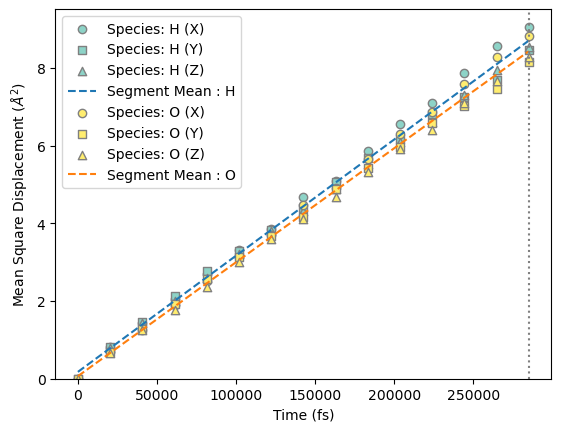

---
Species:    H
---
Segment     0:         Diffusion Coefficient = 0.0000299309 Å^2/fs; Intercept = 0.1752345653 Å^2;
---
Species:    O
---
Segment     0:         Diffusion Coefficient = 0.0000293577 Å^2/fs; Intercept = 0.0644135550 Å^2;
---
Mean Diffusion Coefficient (X, Y and Z) : H = 0.0000299309 Å^2/fs; Std. Dev. = 0.0000012264 Å^2/fs
Mean Diffusion Coefficient (X, Y and Z) : O = 0.0000293577 Å^2/fs; Std. Dev. = 0.0000011755 Å^2/fs
---


[[3.0471120227838183e-05, 2.988759461435139e-05],
 [1.2485749072549382e-06, 1.1967503584273695e-06]]

In [1115]:
dc.calculate(ignore_n_images=0)
dc.plot()
dc.print_data()
[ [__*10**-1 for __ in _] for _ in dc.get_diffusion_coefficients() ]

In [1089]:
MSD = msd.EinsteinMSD(u, select='name OH2', msd_type='xyz', fft=True)
MSD.run()

In [1090]:
_msd =  MSD.results.timeseries

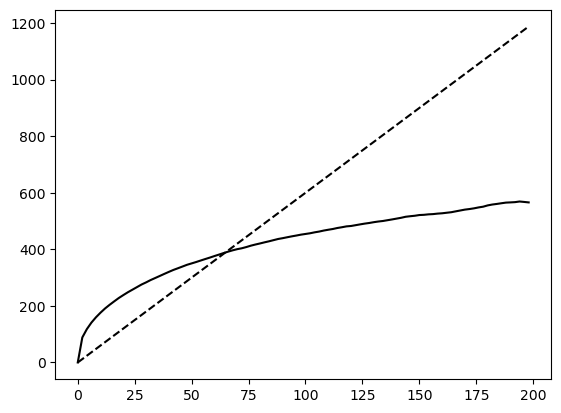

In [1091]:
nframes = MSD.n_frames
timestep = 10000 * 0.0002 # this needs to be the actual time between frames
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, _msd, c="black", ls="-", label=r'3D random walk')
exact = lagtimes*6
# plot the exact result
ax.plot(lagtimes, exact, c="black", ls="--", label=r'$y=2 D\tau$')
plt.show()

In [1097]:

start_time = 50
start_index = int(start_time/timestep)
end_index = -1
# end_time = 
linear_model = linregress(lagtimes[start_index:end_index],
                                              _msd[start_index:end_index])
slope = linear_model.slope
error = linear_model.rvalue
# dim_fac is 3 as we computed a 3D msd with 'xyz'
D = slope * 1/(2*MSD.dim_fac)

In [1098]:
D / 0.1

2.3715130252360668

In [1094]:
atoms.masses

array([15.9994,  1.008 ,  1.008 , ..., 15.9994,  1.008 ,  1.008 ])

In [34]:
# view(ase_atoms, viewer="x3d")
# import nglview as nv

In [35]:

# ase_atoms.set_center_of_mass(u.dimensions[:3]/2)

In [37]:

# plot_atoms(ase_atoms)